## Emotika: Emotion Detection in Text


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# stopword removal
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [2]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [3]:
train_data = pd.read_csv('data/raw/train.txt', sep=';',
                         header=None, names=['text', 'emotion'])
test_data = pd.read_csv('data/raw/test.txt', sep=';',
                        header=None, names=['text', 'emotion'])
val_data = pd.read_csv('data/raw/val.txt', sep=';',
                       header=None, names=['text', 'emotion'])

train_data.describe()

,text,emotion
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


<Axes: xlabel='emotion'>

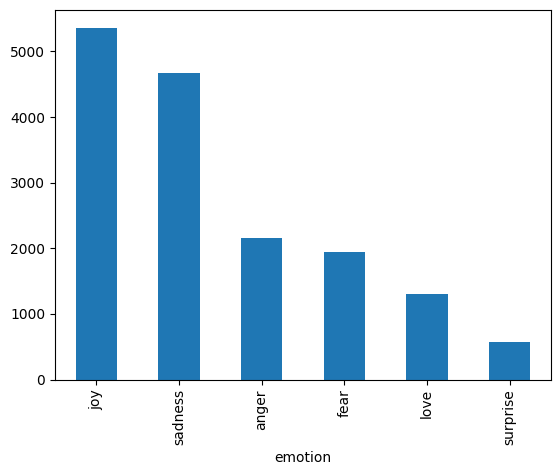

In [4]:
train_data['emotion'].value_counts().plot(kind='bar')

In [5]:
emotions_map = {
    'joy': 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise': 5,
}

In [6]:
train_data["emotion"] = train_data["emotion"].map(emotions_map)
test_data["emotion"] = test_data["emotion"].map(emotions_map)
val_data["emotion"] = val_data["emotion"].map(emotions_map)

train_data.head()

,text,emotion
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,2
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,2


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abdulmunim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

In [9]:
# remove from df
train_data['text'] = train_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)
val_data['text'] = val_data['text'].apply(remove_stopwords)

In [10]:
# Tokenizer

filter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(filters=filter, lower=True)
tokenizer.fit_on_texts(train_data['text'])

word2index = tokenizer.word_index

In [11]:
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_val_seq = tokenizer.texts_to_sequences(val_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_data['text'])

In [20]:
def get_max_length(X):
    return max([len(x) for x in X])


max_length = 50  # get_max_length(X_train_seq)

In [37]:
# Pad sequences to ensure uniform length

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

y_train = to_categorical(train_data['emotion'].values)
y_val = to_categorical(val_data['emotion'].values)
y_test = to_categorical(test_data['emotion'].values)

In [38]:
print(y_train.shape, y_val.shape, y_test.shape)
# the x too
print(X_train_padded.shape, X_val_padded.shape, X_test_padded.shape)

(16000, 6) (2000, 6) (2000, 6)
(16000, 50) (2000, 50) (2000, 50)


## Embeddings


In [22]:
content = []
with open("models/pretrained/glove.6B.100d.txt", "r", encoding="utf-8") as f:
    content = f.readlines()

embeddings_index = {}
for line in content:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [23]:
embed_size = 100
embeddings_matrix = np.zeros((len(word2index) + 1, embed_size))

for word, i in word2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [41]:
model = Sequential([
    Embedding(input_dim=len(word2index)+1,
              output_dim=embed_size,
              input_length=max_length,
              weights=[embeddings_matrix],
              ),
    SpatialDropout1D(0.5),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5,
         name='lstm1', return_sequences=True),
    Conv1D(filters=128, kernel_size=10, strides=3,
           padding="valid", activation='relu', name='conv1d1'),
    Dropout(0.5, name='dropout1'),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5,
         name='lstm2', return_sequences=True),
    Conv1D(filters=128, kernel_size=10, strides=3,
           padding="valid", activation='relu', name='conv1d2'),
    Dropout(0.5, name='dropout2'),
    GlobalMaxPooling1D(),
    Dense(len(emotions_map), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           1506300   
                                                                 
 spatial_dropout1d_7 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 lstm1 (LSTM)                (None, 50, 128)           117248    
                                                                 
 conv1d1 (Conv1D)            (None, 14, 128)           163968    
                                                                 
 dropout1 (Dropout)          (None, 14, 128)           0         
                                                                 
 lstm2 (LSTM)                (None, 14, 128)           131584    
                                                      

In [42]:
# Train the model
history = model.fit(X_train_padded, y_train, batch_size=128,
                    epochs=25, validation_data=(X_val_padded, y_val))

Epoch 1/25
125/125 [==============================] - 25s 154ms/step - loss: 1.5304 - accuracy: 0.4045 - val_loss: 1.3389 - val_accuracy: 0.5370
Epoch 2/25
125/125 [==============================] - 18s 146ms/step - loss: 1.3968 - accuracy: 0.4701 - val_loss: 1.1631 - val_accuracy: 0.6215
Epoch 3/25
125/125 [==============================] - 18s 143ms/step - loss: 1.2155 - accuracy: 0.5496 - val_loss: 0.8911 - val_accuracy: 0.7010
Epoch 4/25
125/125 [==============================] - 17s 139ms/step - loss: 1.0097 - accuracy: 0.6355 - val_loss: 0.5758 - val_accuracy: 0.7945
Epoch 5/25
125/125 [==============================] - 18s 145ms/step - loss: 0.7690 - accuracy: 0.7301 - val_loss: 0.3979 - val_accuracy: 0.8620
Epoch 6/25
125/125 [==============================] - 18s 144ms/step - loss: 0.5874 - accuracy: 0.7919 - val_loss: 0.2808 - val_accuracy: 0.9020
Epoch 7/25
125/125 [==============================] - 18s 140ms/step - loss: 0.4810 - accuracy: 0.8322 - val_loss: 0.2442 - val_ac

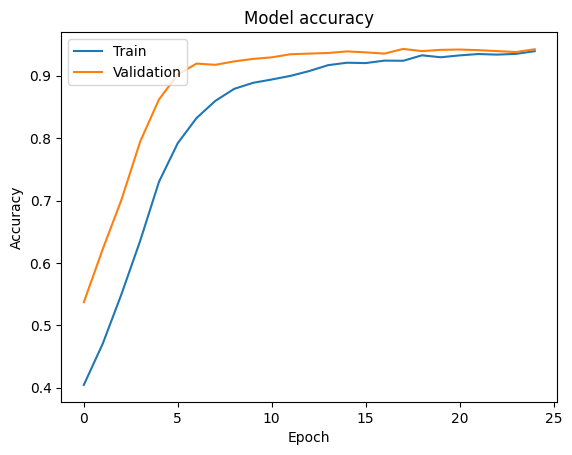

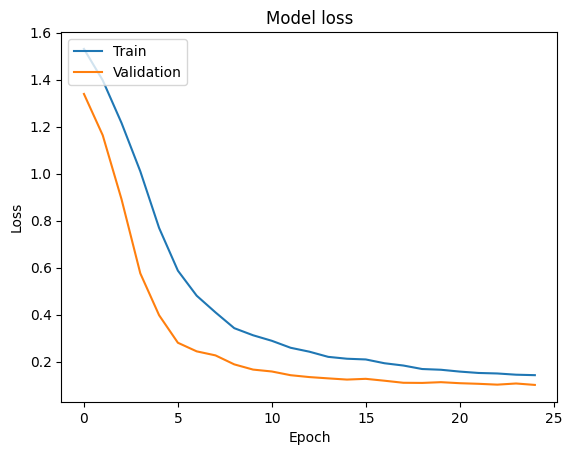

In [43]:
plot_training_history(history)

In [44]:
# Accuracy Time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [45]:
y_pred = model.predict(X_test_padded)

63/63 [==============================] - 2s 13ms/step


In [46]:
print(classification_report(test_data["emotion"], y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       695
           1       0.96      0.98      0.97       581
           2       0.93      0.95      0.94       275
           3       0.90      0.92      0.91       224
           4       0.82      0.88      0.85       159
           5       0.90      0.68      0.78        66

    accuracy                           0.94      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.94      0.94      0.94      2000



In [49]:
confusion_matrix(test_data["emotion"], y_pred.argmax(axis=1))

array([[657,   1,   2,   0,  30,   5],
       [  1, 570,   7,   3,   0,   0],
       [  2,  11, 260,   2,   0,   0],
       [  0,   8,  10, 206,   0,   0],
       [ 19,   0,   0,   0, 140,   0],
       [  1,   1,   0,  19,   0,  45]], dtype=int64)

In [50]:
def save_model(model, model_name):
    model.save(f'models/{model_name}.h5')
    print(f'Model saved as {model_name}.h5')

In [52]:
save_model(model, 'glove_NN_model')

Model saved as glove_NN_model.h5


In [53]:
# save the tokenization and preprocessing

import pickle


def save_tokenizer(tokenizer, tokenizer_name):
    with open(f'models/{tokenizer_name}.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'Tokenizer saved as {tokenizer_name}.pickle')

In [54]:
save_tokenizer(tokenizer, 'glove_NN_tokenizer')

Tokenizer saved as glove_NN_tokenizer.pickle
